# Data Preparation
- This notebook is used to visualize and prepare power trace data for our transformer model.

In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

## Find and load the data

In [2]:
def discover_experiment_pairs(data_root_dir: str) -> List[Tuple[str, str]]:
        """
        Finds matching pairs of power CSVs and results CSVs based on
        {MODEL_NAME}_tp{TP}_p{RATE}_d{DATE}.csv and
        results_{MODEL_NAME}_{RATE}_{TP}_final.csv.

        Returns:
            A list of (power_csv_path, results_csv_path).
        """
        all_csvs = glob.glob(
            os.path.join(data_root_dir, "**", "*.csv"), recursive=True
        )
        print(f"Found {len(all_csvs)} CSV files in {data_root_dir}")

        # Separate into "power" files vs "results" files
        power_files = []
        results_files = []

        for csv_path in all_csvs:
            base = os.path.basename(csv_path)
            if base.startswith("results_"):
                results_files.append(csv_path)
            else:
                # Likely a power file if it has _tp and _p in the name
                if "_tp" in base and "_p" in base:
                    power_files.append(csv_path)

        print(f"Found {len(power_files)} power files and {len(results_files)} results files")
     # Attempt to match them by extracting model_name, tp, rate

        def extract_power_info(filename: str):
            # Example:  llama-3-8b_tp2_p2.0_d2025-03-14-07-32-35.csv
            base = os.path.basename(filename)
            model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d", base)
            print(model_match.groups())
            if not model_match:
                return None
            model_name = model_match.group(1)
            tp = model_match.group(2)
            rate = model_match.group(3)
            return model_name, tp, rate

        def extract_results_info(filename: str):
            base = os.path.basename(filename)
            result_match = re.match(r"results_(.*)_(\d+\.\d+)_(\d+)_final", base)
            if not result_match:
                return None
            model_name = result_match.group(1)
            rate = result_match.group(2)
            tp = result_match.group(3)
            return model_name, tp, rate

        matched_pairs = []
        for pfile in power_files:
            pinfo = extract_power_info(pfile)
            if not pinfo:
                continue
            p_model, p_tp, p_rate = pinfo

            # Look for a results file that matches
            for rfile in results_files:
                rinfo = extract_results_info(rfile)
                if not rinfo:
                    continue
                r_model, r_tp, r_rate = rinfo

                # Check if they match
                if p_model == r_model and p_tp == r_tp and p_rate == r_rate:
                    matched_pairs.append((pfile, rfile))
                    break  # Found our match, no need to look further

        print(
            f"Found {len(power_files)} power files, {len(results_files)} results files, "
            f"matched {len(matched_pairs)} pairs."
        )
        return matched_pairs

def parse_results_csv(csv_path: str) -> pd.DataFrame:
        """
        Parse the results CSV (e.g. results_{MODEL_NAME}_{RATE}_{TP}_final.csv).

        Expects columns:
        [Request Time, Model, Data Source, Poisson Arrival Rate, Tensor Parallel Size,
         Input Tokens, Output Tokens, E2E Latency]

        Returns:
            Pandas DataFrame with a 'request_time' column (datetime64).
        """
        try:
            df = pd.read_csv(csv_path)
            df.sort_values("Request Time", inplace=True)
            df["Completion Time"] = df["Request Time"] + df["E2E Latency"]
            return df
        except Exception as e:
            print(f"Error reading results file {csv_path}: {e}")
            return pd.DataFrame()

def parse_power_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the GPU power trace CSV and sum up the first X power values of each group of 8 rows,
    where X is the tensor parallelism extracted from the filename (_tpX).
    The timestamp for each sample is taken as the minimum timestamp within the group.
    
    Expects columns (for each GPU row):
        timestamp, power.draw [W], utilization.gpu [%], memory.used [MiB]
    """
    try:
        # Read CSV and clean up column names
        df = pd.read_csv(csv_path, skipinitialspace=True)
        df.columns = [col.strip().lower() for col in df.columns]

        # Rename power and memory columns if needed
        if "power.draw [w]" in df.columns:
            df.rename(columns={"power.draw [w]": "power"}, inplace=True)
            df.rename(columns={"memory.used [mib]": "memory"}, inplace=True)

        # Clean up the power column (remove non-numeric characters and convert to numeric)
        if df["power"].dtype == object:
            df["power"] = df["power"].replace(r"[^\d.]", "", regex=True)
            df["power"] = pd.to_numeric(df["power"])

        # Clean up the memory column if present
        if "memory" in df.columns and df["memory"].dtype == object:
            df["memory"] = df["memory"].replace(r"[^\d.]", "", regex=True)
            df["memory"] = pd.to_numeric(df["memory"])

        # Identify the timestamp column (any column containing "time")
        time_col = None
        for c in df.columns:
            if "time" in c:
                time_col = c
                break
        if not time_col:
            raise ValueError("No timestamp column found in power CSV")

        # Convert timestamps to datetime and rename column to "timestamp"
        df[time_col] = pd.to_datetime(df[time_col])
        df.rename(columns={time_col: "timestamp"}, inplace=True)

        # Extract tensor parallelism from the filename (_tpX -> X)
        tp_match = re.search(r'_tp(\d+)', csv_path)
        tensor_parallelism = int(tp_match.group(1)) if tp_match else 1
        print(f"Extracted tensor parallelism {tensor_parallelism} from {csv_path}")
        

        num_rows = len(df)
        num_complete_groups = num_rows // 8
        df = df.iloc[:num_complete_groups * 8]
        groups = df.groupby(np.arange(len(df)) // 8)

        result = groups.apply(lambda x: pd.Series({
            "timestamp": x["timestamp"].min(),
            "power": x.iloc[:tensor_parallelism]["power"].sum()
        })).reset_index(drop=True)

        result["timestamp"] = pd.to_datetime(result['timestamp']).astype(np.int64) / 10**9

        return result

    except Exception as e:
        print(f"Error reading power file {csv_path}: {e}")
        return pd.DataFrame()
    
def plot_power_val(df: pd.DataFrame, title: str, ylabel: str, xlabel: str, save_path: Optional[str] = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["power"], label="Power")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.yscale("log")
    plt.legCompletion()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [41]:
from sklearn.cluster import KMeans
matched_pairs = discover_experiment_pairs(data_root_dir='../client/')
# Filter out any pairs containing "deepseek" in the power CSV filename
matched_pairs = [
    (power_csv, results_csv) 
    for power_csv, results_csv in matched_pairs 
    if "deepseek" not in power_csv.lower()
]

power_dfs = []
results_dfs = []
kmeans_labels = []
for power_csv, results_csv in matched_pairs:
    print(f"Processing {power_csv} and {results_csv}")
    power_df = parse_power_csv(power_csv)
    results_df = parse_results_csv(results_csv)
    power_dfs.append(power_df)
    results_dfs.append(results_df)


Found 143 CSV files in ../client/
Found 49 power files and 94 results files
('llama-3-8b', '2', '2.0')
('llama-3-8b', '1', '1.0')
('llama-3-8b', '8', '4.0')
('llama-3-8b', '4', '1.0')
('llama-3-8b', '8', '0.125')
('llama-3-8b', '2', '0.5')
('llama-3-8b', '1', '0.5')
('llama-3-8b', '8', '0.5')
('llama-3-8b', '2', '1.0')
('llama-3-8b', '4', '2.0')
('llama-3-8b', '2', '1.0')
('llama-3-8b', '1', '0.25')
('llama-3-8b', '2', '0.125')
('llama-3-8b', '8', '1.0')
('llama-3-8b', '2', '4.0')
('llama-3-8b', '2', '4.0')
('llama-3-8b', '8', '0.25')
('llama-3-8b', '4', '0.125')
('llama-3-8b', '4', '0.25')
('llama-3-8b', '1', '0.125')
('llama-3-8b', '1', '2.0')
('llama-3-8b', '2', '0.25')
('llama-3-8b', '4', '4.0')
('llama-3-8b', '8', '2.0')
('llama-3-8b', '4', '0.5')
('deepseek-r1-distill-8b', '8', '0.125')
('deepseek-r1-distill-8b', '2', '0.125')
('deepseek-r1-distill-8b', '1', '0.5')
('deepseek-r1-distill-8b', '2', '0.25')
('deepseek-r1-distill-8b', '8', '2.0')
('deepseek-r1-distill-8b', '2', '2.0'

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/1589912138.py:138: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col])


Processing ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_1_final.csv
Extracted tensor parallelism 1 from ../client/llama-3-8b/llama-3-8b_tp1_p0.5_d2025-03-13-18-28-09.csv
Processing ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv and ../client/llama-3-8b/results_llama-3-8b_0.5_8_final.csv
Extracted tensor parallelism 8 from ../client/llama-3-8b/llama-3-8b_tp8_p0.5_d2025-03-14-00-42-29.csv
Processing ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-23.csv and ../client/llama-3-8b/results_llama-3-8b_1.0_2_final.csv
Extracted tensor parallelism 2 from ../client/llama-3-8b/llama-3-8b_tp2_p1.0_d2025-03-14-07-17-23.csv
Processing ../client/llama-3-8b/llama-3-8b_tp4_p2.0_d2025-03-13-22-16-11.csv and ../client/llama-3-8b/results_llama-3-8b_2.0_4_final.csv
Extracted tensor parallelism 4 from ../client/llama-3-8b/llama-3-8b_tp4_p2.0_d2025-03-13-22-16-11.csv
Processing ../client/llama-3-8b/llama-3-8b_t

## Truncate the data down to the final request 

Startup time:  5.5395729541778564
Shutdown time:  604.7249219417572


/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/1945239432.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/1945239432.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["input_tokens"] = input_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/1945239432.py:57: SettingWithCopyWarning: 
A value is trying to

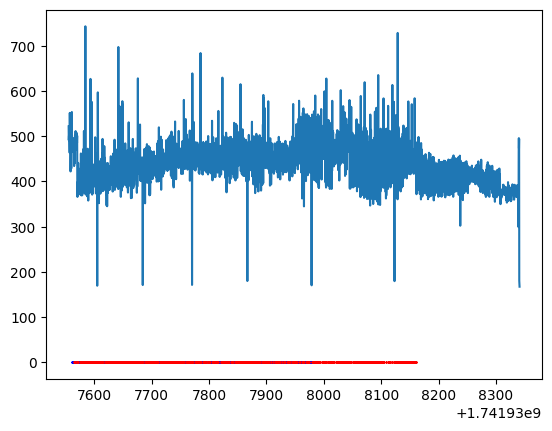

In [46]:
def add_token_columns_to_power_df(power_df: pd.DataFrame, results_df: pd.DataFrame) -> pd.DataFrame:
    """
    For each 250ms window in power_df, compute the tokens that are being processed by 
    distributing each query's token counts across its processing duration.
    
    Args:
        power_df: DataFrame with a 'timestamp' column (in seconds relative to experiment start).
        results_df: DataFrame from the results CSV. Expects columns:
            - "Request Time" (datetime64)
            - "Completion Time" (datetime64)
            - "Input Tokens"
            - "Output Tokens"
    
    Returns:
        The original power_df with two added columns:
            - "input_tokens": the fraction of input tokens processed in that 250ms window.
            - "output_tokens": the fraction of output tokens processed in that 250ms window.
    """
    # Use the earliest request time as the reference (assumes power_df was truncated accordingly)
    start_time = results_df["Request Time"].min()
    
    # Create new columns with times in seconds relative to start_time
    results_df = results_df.copy()
    results_df["req_sec"] = (results_df["Request Time"] - start_time)
    results_df["comp_sec"] = (results_df["Completion Time"] - start_time)
    
    window_duration = 0.25
    input_tokens_list = []
    output_tokens_list = []

    for t in power_df["timestamp"]:
        window_start = t
        window_end = t + window_duration
        
        overlapping = results_df[(results_df["comp_sec"] > window_start) & (results_df["req_sec"] < window_end)]
        
        total_input = 0.0
        total_output = 0.0
        
        # For each overlapping query, compute the fraction of the query's tokens that were processed in this window.
        for _, row in overlapping.iterrows():
            q_start = row["req_sec"]
            q_end = row["comp_sec"]
            # Compute the overlap (in seconds) between the query interval and the window
            overlap = max(0.0, min(window_end, q_end) - max(window_start, q_start))
            query_duration = q_end - q_start
            if query_duration > 0:
                fraction = overlap / query_duration
                total_input += row["Input Tokens"] * fraction
                total_output += row["Output Tokens"] * fraction
        
        input_tokens_list.append(total_input)
        output_tokens_list.append(total_output)
    
    # Add the new columns to the power_df
    power_df["input_tokens"] = input_tokens_list
    power_df["output_tokens"] = output_tokens_list
    return power_df

plt.plot(power_dfs[0]["timestamp"], power_dfs[0]["power"], label="Power")
plt.scatter(results_dfs[0]["Request Time"], [0] * len(results_dfs[0]), c="blue", marker="x", label="Request Time", s=1)
plt.scatter(results_dfs[0]["Completion Time"], [0] * len(results_dfs[0]), c="red", marker="x", label="Completion Time", s=1)
print("Startup time: ", results_dfs[0]["Request Time"].min() - power_dfs[0]['timestamp'].min())
print("Shutdown time: ", results_dfs[0]["Completion Time"].max() - power_dfs[0]['timestamp'].min())

truncated_power_dfs = []
for i in range(len(power_dfs)):
    startup_cutoff = results_dfs[i]["Request Time"].min()
    shutdown_cutoff = results_dfs[i]["Completion Time"].max()
    truncated_power_dfs.append(power_dfs[i][(power_dfs[i]['timestamp'] > startup_cutoff) & (power_dfs[i]['timestamp'] < shutdown_cutoff)])
    truncated_power_dfs[i].reset_index(drop=True, inplace=True)
    truncated_power_dfs[i]['timestamp'] -= truncated_power_dfs[i]['timestamp'].min()

for i in range(len(truncated_power_dfs)):
    truncated_power_dfs[i] = add_token_columns_to_power_df(truncated_power_dfs[i], results_dfs[i])

output_path = "processed_data/power_trace_data.npz"
input_tokens = []
output_tokens = []
tensor_parallelism = []
poisson_rate = []
model_sizes = [] 
power_traces = []

# First pass to get max length
max_len = max([len(df) for df in truncated_power_dfs])

for i in range(len(truncated_power_dfs)):
    tensor_parallelism.append(results_dfs[i]["Tensor Parallel Size"].iloc[0])
    poisson_rate.append(results_dfs[i]["Poisson Arrival Rate"].iloc[0])
    model_sizes.append(results_dfs[i]["Input Tokens"].iloc[0])
    
    # Pad power traces and token arrays to max length
    power_trace = truncated_power_dfs[i]["power"].values
    input_token = truncated_power_dfs[i]["input_tokens"].values
    output_token = truncated_power_dfs[i]["output_tokens"].values
    
    # Apply rolling mean to all traces (20 samples = 5 seconds at 250ms intervals)
    power_trace = pd.Series(power_trace).rolling(window=20, min_periods=1).mean().values
    input_token = pd.Series(input_token).rolling(window=20, min_periods=1).mean().values
    output_token = pd.Series(output_token).rolling(window=20, min_periods=1).mean().values
    
    # Pad with zeros to maintain homogeneity
    power_trace = np.pad(power_trace, (0, max_len - len(power_trace)), 'edge')
    input_token = np.pad(input_token, (0, max_len - len(input_token)), 'constant', constant_values=0)
    output_token = np.pad(output_token, (0, max_len - len(output_token)), 'constant', constant_values=0)
    
    power_traces.append(power_trace)
    input_tokens.append(input_token)
    output_tokens.append(output_token)

# Convert to numpy arrays
power_traces = np.array(power_traces)
tensor_parallelism = np.array(tensor_parallelism)
poisson_rate = np.array(poisson_rate)
model_sizes = np.array(model_sizes)
input_tokens = np.array(input_tokens)
output_tokens = np.array(output_tokens)

np.savez(output_path, 
         power_traces=power_traces, 
         tensor_parallelism=tensor_parallelism, 
         poisson_rate=poisson_rate, 
         model_sizes=model_sizes, 
         input_tokens=input_tokens, 
         output_tokens=output_tokens)


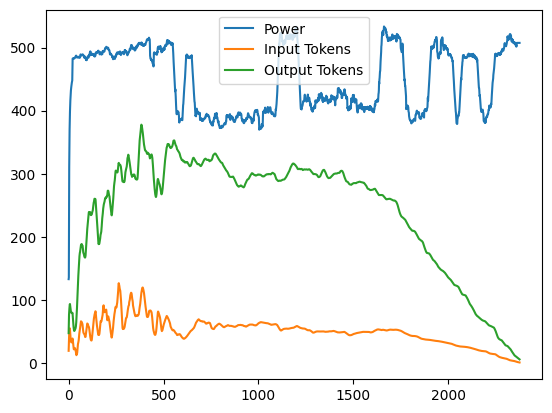

In [47]:
plt.plot(power_traces[10], label="Power")
plt.plot(input_tokens[20], label="Input Tokens")
plt.plot(output_tokens[20], label="Output Tokens")
plt.legend()

Contents of processed_data/power_trace_data.npz:
  - power_traces: shape (49, 2120), type float64
  - tensor_parallelism: shape (49,), type int64
  - poisson_rate: shape (49,), type float64
  - model_sizes: shape (49,), type int64

Power trace statistics:
  - Min: 63.65W
  - Max: 1536.15W
  - Mean: 572.04W
  - Std: 282.61W


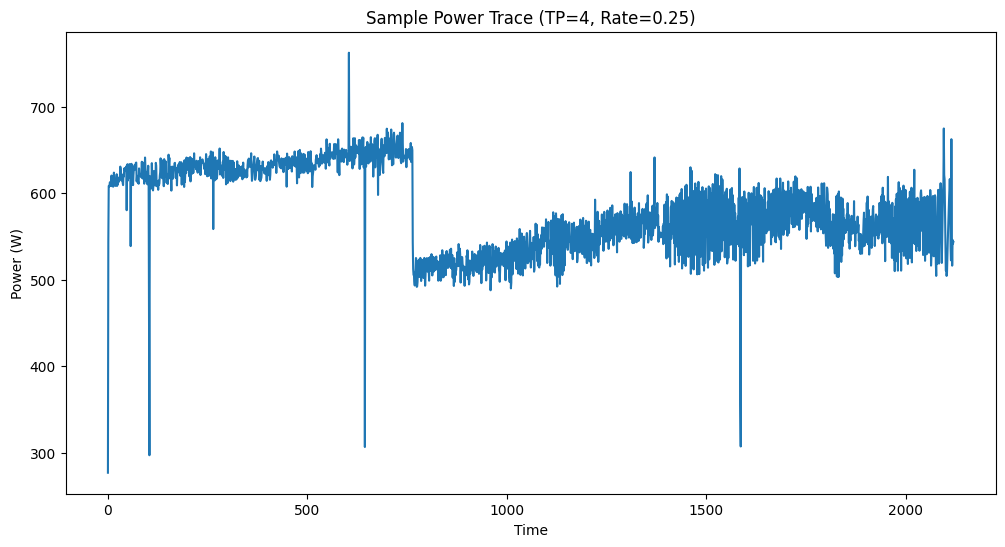

In [ ]:
from numpy.lib.npyio import NpzFile
def analyze_power_trace_data(npz_path) -> NpzFile:
    """
    Analyze the created power_trace_data.npz file.
    """
    data = np.load(npz_path)
    print(f"Contents of {npz_path}:")
    for key in data.files:
        print(f"  - {key}: shape {data[key].shape}, type {data[key].dtype}")
    
    # Analyze power traces
    power_traces = data['power_traces']
    print(f"\nPower trace statistics:")
    print(f"  - Min: {power_traces.min():.2f}W")
    print(f"  - Max: {power_traces.max():.2f}W")
    print(f"  - Mean: {power_traces.mean():.2f}W")
    print(f"  - Std: {power_traces.std():.2f}W")
    
    # Plot a sample power trace
    plt.figure(figsize=(12, 6))
    sample_idx = np.random.randint(len(power_traces))
    plt.plot(power_traces[sample_idx])
    plt.title(f"Sample Power Trace (TP={data['tensor_parallelism'][sample_idx]}, Rate={data['poisson_rate'][sample_idx]})")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.show()
    
    # If state sequences exist, plot them as well
    if 'state_sequences' in data and data['state_sequences'].size > 0:
        plt.figure(figsize=(12, 6))
        state_seq = data['state_sequences'][sample_idx]
        plt.plot(state_seq)
        plt.title("State Sequence")
        plt.xlabel("Time")
        plt.ylabel("State")
        plt.show()
    
    return data

data = analyze_power_trace_data(output_path)

/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/722328506.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["input_tokens"] = input_tokens_list
/var/folders/3j/5n1r8yyx2d58jn87prrxs_lm0000gn/T/ipykernel_87899/722328506.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df["output_tokens"] = output_tokens_list


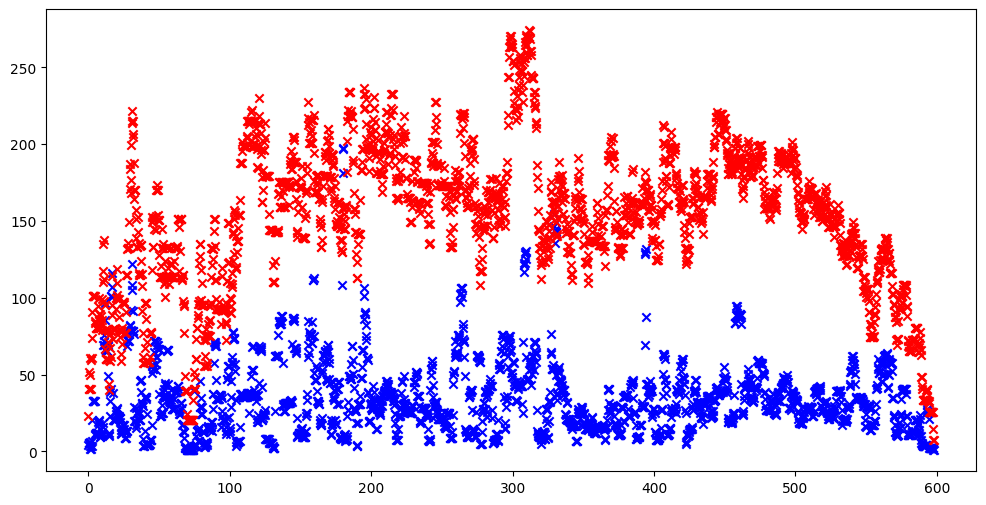

In [7]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

class PowerTraceHSMMDataset(Dataset):
    """
    Enhanced dataset for power trace modeling with HSMM states.
    
    This dataset:
    1. Identifies discrete states in power traces
    2. Generates state sequences and durations
    3. Returns both power traces and state information
    """
    def __init__(
        self,
        power_traces: np.ndarray,  # [N, T]
        tensor_parallelism: np.ndarray,  # [N]
        poisson_rate: np.ndarray,  # [N]
        model_size: np.ndarray,  # [N] (in billions of parameters)
        valid_indices: np.ndarray,  # [M, 2], each row = (sample_idx, start_idx)
        sequence_length: int,
        n_states: int = 6,
        state_identifier=None,
    ):
        super().__init__()
        self.power_traces = power_traces
        self.tensor_parallelism = tensor_parallelism
        self.poisson_rate = poisson_rate
        self.model_size = model_size
        self.valid_indices = valid_indices
        self.sequence_length = sequence_length
        self.n_states = n_states
        
        if state_identifier is None:
            print("Identifying states in power traces...")
            self.state_identifier = KMeans(n_clusters=n_states, random_state=42)
            flat_data = power_traces.reshape(-1, 1)
            self.state_identifier.fit(flat_data)
            self.state_sequences = np.zeros_like(power_traces, dtype=np.int32)
            for i in range(len(power_traces)):
                self.state_sequences[i] = self.state_identifier.predict(
                    power_traces[i].reshape(-1, 1)
                )
        else:
            self.state_identifier = state_identifier
            self.state_sequences = np.zeros_like(power_traces, dtype=np.int32)
            for i in range(len(power_traces)):
                self.state_sequences[i] = self.state_identifier.predict(
                    power_traces[i].reshape(-1, 1)
                )
        
        self.state_centroids = self.state_identifier.cluster_centers_
        self.analyze_states()
    
    def analyze_states(self):
        """Analyze state transitions and durations in the dataset"""
        # Count occurrences of each state
        state_counts = np.zeros(self.n_states, dtype=np.int32)
        for seq in self.state_sequences:
            unique, counts = np.unique(seq, return_counts=True)
            for state, count in zip(unique, counts):
                state_counts[state] += count
        
        # Calculate average duration for each state
        self.avg_durations = np.zeros(self.n_states, dtype=np.float32)
        duration_counts = np.zeros(self.n_states, dtype=np.int32)
        
        for seq in self.state_sequences:
            current_state = seq[0]
            current_duration = 1
            
            for i in range(1, len(seq)):
                if seq[i] == current_state:
                    current_duration += 1
                else:
                    self.avg_durations[current_state] += current_duration
                    duration_counts[current_state] += 1
                    current_state = seq[i]
                    current_duration = 1
            self.avg_durations[current_state] += current_duration
            duration_counts[current_state] += 1

        duration_counts = np.maximum(duration_counts, 1)
        self.avg_durations /= duration_counts
        self.transition_matrix = np.zeros((self.n_states, self.n_states), dtype=np.int32)
        for seq in self.state_sequences:
            for i in range(len(seq) - 1):
                self.transition_matrix[seq[i], seq[i+1]] += 1
        row_sums = self.transition_matrix.sum(axis=1, keepdims=True)
        row_sums = np.maximum(row_sums, 1)
        self.transition_probs = self.transition_matrix / row_sums
        
        print(f"State analysis complete:")
        print(f"  - State counts: {state_counts}")
        print(f"  - Average durations: {self.avg_durations}")
        print(f"  - State centroids: {self.state_centroids.flatten()}")
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        sample_idx, start_idx = self.valid_indices[idx]

        power_seq = self.power_traces[sample_idx][start_idx:start_idx + self.sequence_length]
        power_seq = torch.tensor(power_seq, dtype=torch.float32)
        state_seq = self.state_sequences[sample_idx][start_idx:start_idx + self.sequence_length]
        state_seq = torch.tensor(state_seq, dtype=torch.long)
        config_vec = torch.tensor(
            [
                self.tensor_parallelism[sample_idx], 
                self.poisson_rate[sample_idx],
                self.model_size[sample_idx]
            ],
            dtype=torch.float32,
        )
        input_seq = torch.cat([torch.zeros(1), power_seq[:-1]], dim=0)
        
        return {
            "config": config_vec,         # [3]
            "input_seq": input_seq,       # [seq_len]
            "target_seq": power_seq,      # [seq_len]
            "state_seq": state_seq,       # [seq_len]
        }


def prepare_hsmm_dataset(power_traces, tensor_parallelism, poisson_rate, model_size, sequence_length=2400, n_states=6):
    """
    Prepare datasets for HSMM-Transformer model training.
    
    Args:
        power_traces: Power trace data [N, T]
        tensor_parallelism: Tensor parallelism values [N]
        poisson_rate: Poisson arrival rates [N]
        model_size: Model sizes in billions of parameters [N]
        sequence_length: Length of sequences to use
        n_states: Number of states to identify
        
    Returns:
        train_loader: DataLoader for training
        val_loader: DataLoader for validation
        state_identifier: Fitted state identifier
    """
    # Create valid indices (just an example, adjust as needed)
    N, T = power_traces.shape
    valid_indices = []
    for i in range(N):
        for j in range(0, T - sequence_length + 1, sequence_length // 2):
            valid_indices.append((i, j))
    valid_indices = np.array(valid_indices)
    
    dataset = PowerTraceHSMMDataset(
        power_traces=power_traces,
        tensor_parallelism=tensor_parallelism,
        poisson_rate=poisson_rate,
        model_size=model_size,
        valid_indices=valid_indices,
        sequence_length=sequence_length,
        n_states=n_states
    )
    
    # Split into train and validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
    )
    
    return train_loader, val_loader, dataset.state_identifier

power_traces = np.load("processed_data/power_trace_data.npz")["power_traces"]
tensor_parallelism = np.load("processed_data/power_trace_data.npz")["tensor_parallelism"]
poisson_rate = np.load("processed_data/power_trace_data.npz")["poisson_rate"]
model_size = np.load("processed_data/power_trace_data.npz")["model_sizes"]

train_loader, val_loader, state_identifier = prepare_hsmm_dataset(power_traces, tensor_parallelism, poisson_rate, model_size)
print(f"Train dataset: {len(train_loader.dataset)} samples")
print(f"Validation dataset: {len(val_loader.dataset)} samples")


Identifying states in power traces...
State analysis complete:
  - State counts: [19033 41018  5058 30009  5829  2933]
  - Average durations: [19.441267 14.158785 29.578947 11.960542 14.321867  8.729167]
  - State centroids: [ 810.40701956  530.71146172 1326.20313167  303.50642957 1030.83283828
  125.52998284]


ValueError: num_samples should be a positive integer value, but got num_samples=0